## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")

In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Data Preparation

In [5]:
from models.utils.s3_config_manager import S3ConfigManager

# Initialize S3 config manager
s3_manager = S3ConfigManager()

✅ S3 connection successful. Bucket: bio-data


In [10]:
simulation_data = s3_manager.load_data_from_path("new-peak-project/experiments/matlab_output/ground_truth_data.csv", data_format="csv")

In [11]:
from scripts.matlab.load_time_course_data import load_timecourse_data
from scripts.matlab.load_target_data import load_target_data

In [12]:
ground_time_course_data = load_timecourse_data(simulation_data, index_option='cell_id')
target_data = load_target_data(simulation_data, 'pERK', index_option='cell_id')

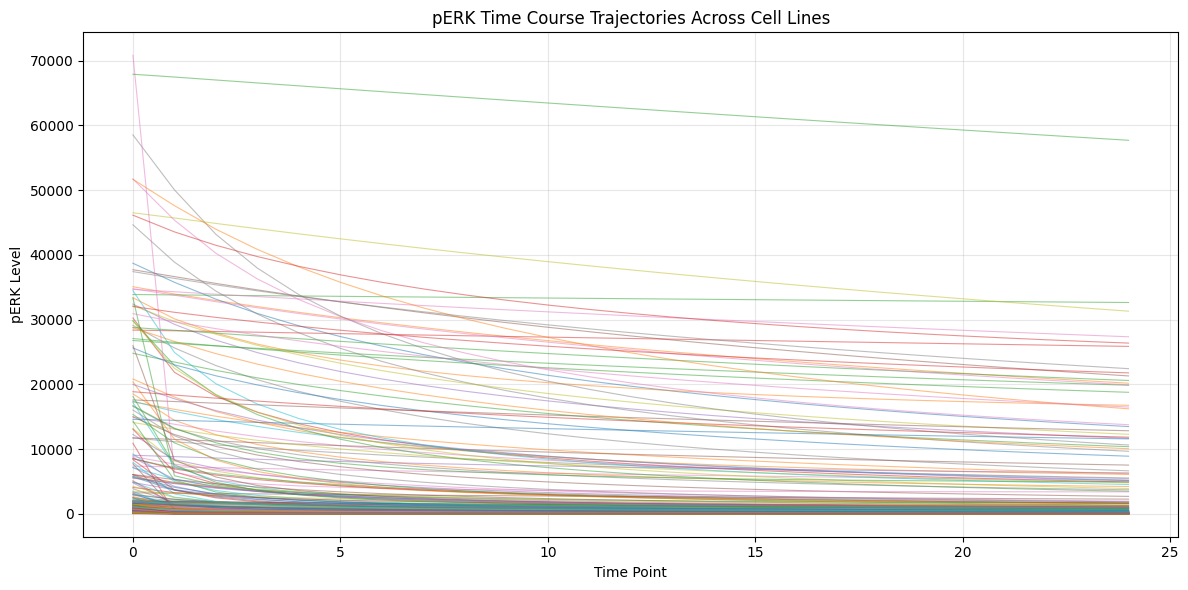

In [14]:
import numpy as np

import matplotlib.pyplot as plt

# Extract pERK column
perk_data = ground_time_course_data['pERK']

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each cell line's trajectory
for cell_id, trajectory in perk_data.items():
    plt.plot(trajectory, alpha=0.5, linewidth=0.8)

plt.xlabel('Time Point')
plt.ylabel('pERK Level')
plt.title('pERK Time Course Trajectories Across Cell Lines')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

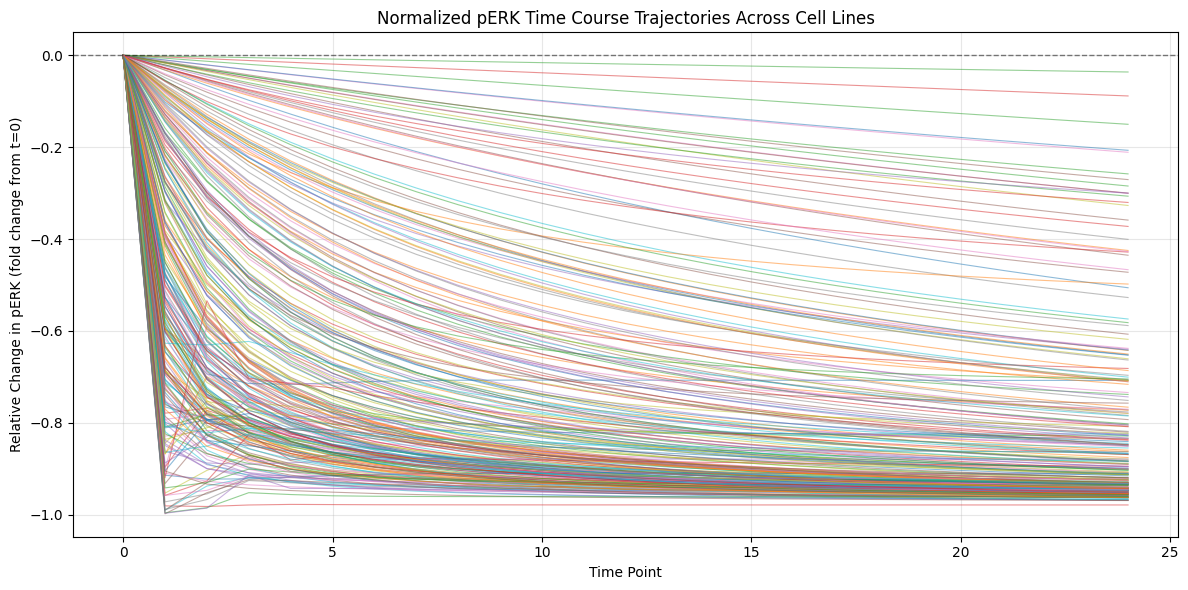

In [15]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot each cell line's normalized trajectory
for cell_id, trajectory in perk_data.items():
    # Normalize: subtract initial value and divide by initial value
    traj_array = np.array(trajectory)
    normalized_traj = (traj_array - traj_array[0]) / traj_array[0]
    plt.plot(normalized_traj, alpha=0.5, linewidth=0.8)

plt.xlabel("Time Point")
plt.ylabel("Relative Change in pERK (fold change from t=0)")
plt.title("Normalized pERK Time Course Trajectories Across Cell Lines")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
all_species = list(ground_time_course_data.columns)
# remove 'pERK' from all_species
all_species.remove('pERK')

In [ ]:
from models.Utils import last_time_point_method, dynamic_features_method

last_time_data = last_time_point_method(ground_time_course_data, all_species)
dynamic_data = dynamic_features_method(ground_time_course_data, all_species, n_cores=8)

In [ ]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)

In [ ]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

In [ ]:
o_random_seed = 42
target_name = 'pERK'